In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import StateSpace, lsim
from torch import nn
import torch
import torchvision
plt.rcParams.update({
    "text.usetex": True,
    })


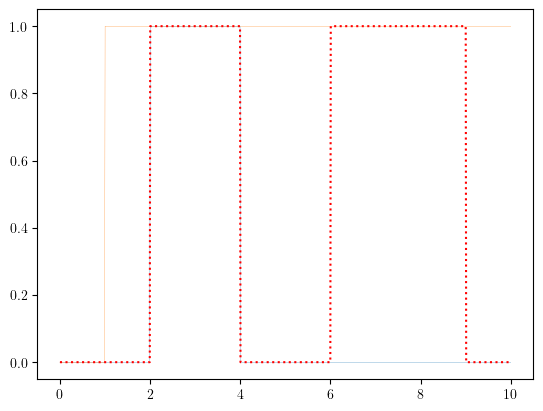

In [29]:
# Zeitpunkte für die Simulation
t = np.linspace(0, 10, 1000)  # von 0 bis 10 Sekunden, 1000 Schritte

def heaviside_vectorized(x,t0):
    return np.where(t < 0, 0, np.where(t > t0, 1, 0))


def rectangle_impulse(x,t1,t2):
    return heaviside_vectorized(x,t1) - heaviside_vectorized(x,t2)

# Amplitudenmodulierte Pseudo-Rausch-Binär-Signal
def APRBS(t, amplitude1 = -1, amplitude2 = 1, freq0 = 1, freq1 = 25):
    pass


signal = rectangle_impulse(t,2,4)
signal2 = heaviside_vectorized(t,1)
u = rectangle_impulse(t,2,4) + rectangle_impulse(t,6,9)

plt.plot(t,signal,linewidth=0.2)
plt.plot(t,signal2, linewidth=0.2)
plt.plot(t,u,linestyle=':', c="r")
plt.show()




In [30]:
# Parameter festlegen
m1 = 1  # Masse 1
m2 = 2  # Masse 2
k1 = 10  # Federkonstante 1
k2 = 5  # Federkonstante 2
b1 = 0.5  # Reibung 1
b2 = 0.2  # Reibung 2

# Zustandsraummodell definieren
A = np.array([
    [0, 1, 0, 0],
    [-(k1/m1), -(b1/m1), k2/m1, 0],
    [0, 0, 0, 1],
    [k2/m2, 0, -(k2/m2), -(b2/m2)]
])

B = np.array([
    [0],
    [1],
    [0],
    [0]
])

C = np.array([
    [1, 0, -1, 0],
    [0, 0, 1, 0]
])

D = np.array([
    [0],
    [0]
])

# System erstellen
sys = StateSpace(A, B, C, D)

# Zeitpunkte für die Simulation

number_samples = 4000
T = 10      # 10sec
t = np.linspace(0, T, number_samples)  # von 0 bis 10 Sekunden, 1000 Schritte
# Anregungssignal (hier: keine Anregung)
#u = np.random.rand(len(t))*20
u = rectangle_impulse(t,2,4) + rectangle_impulse(t,6,9)
u = u*0 #########################################
#########################################33
############################################333 
########## u = 0!!! hier in diesem fall

# Anfangszustand (hier: Nullzustand)
x0 = np.zeros((4,))

# System simulieren
t_out, y_out, x_out = lsim(sys, U=u, T=t, X0=x0)

# y_out enthält die simulierten Ausgangsgrößen
# t_out enthält die Zeitpunkte der Simulation
# x_out enthält die Zustände des Systems während der Simulation
# Speichern der simulierten Ausgangsgrößen in einer .npy-Datei
np.save('simulated_outputs.npy', y_out)
# Speichern der Zeitpunkte der Simulation in einer .npy-Datei
np.save('simulated_inputs', u)

t_out, y_out, x_out = lsim(sys, U=u, T=t, X0=x0)

np.save('test_outputs.npy', y_out)
# Speichern der Zeitpunkte der Simulation in einer .npy-Datei
np.save('test_input.npy', u)


In [ ]:
# FUNKTION DIE SYSTEM MIT ZUFAELLIG NEUEN ANFANGSZUSTAENDEN SIMULIERT

def randomSystemRun(A,B,C,D):
    number_samples = 4000
    T = 10      # 10sec
    t = np.linspace(0, T, number_samples)  # von 0 bis 10 Sekunden, 1000 Schritte
    # Anregungssignal (hier: keine Anregung)
    #u = np.random.rand(len(t))*20
    u = rectangle_impulse(t,2,4) + rectangle_impulse(t,6,9)
    u = u*0 ######################################### u = 0!!! hier in diesem fall

    # Anfangszustand (hier: zufaellig zwischen -10 und 10
    x0 = np.random.randint((20,20,20,20))-10

    # System simulieren
    t_out, y_out, x_out = lsim(sys, U=u, T=t, X0=x0)

    # numpy array manipulation
    number_states = 4
    k = 15   #number of timesteps we take into account to predict the future.
    n = number_samples-k
    new_x = np.zeros((n,number_states*k))

    for i in range(n):
        new_x[i,:] = x_out[i:i+k].flatten()

    new_y = x_out[k:]

    input_tensor = torch.from_numpy(new_x).float()
    target_tensor = torch.from_numpy(new_y).float()

    input_tensor = input_tensor.unsqueeze(1)  # Adding a dimension to represent sequence length
    target_tensor = target_tensor.unsqueeze(1)  # Adding a dimension to represent sequence length

    return input_tensor, target_tensor
    
    

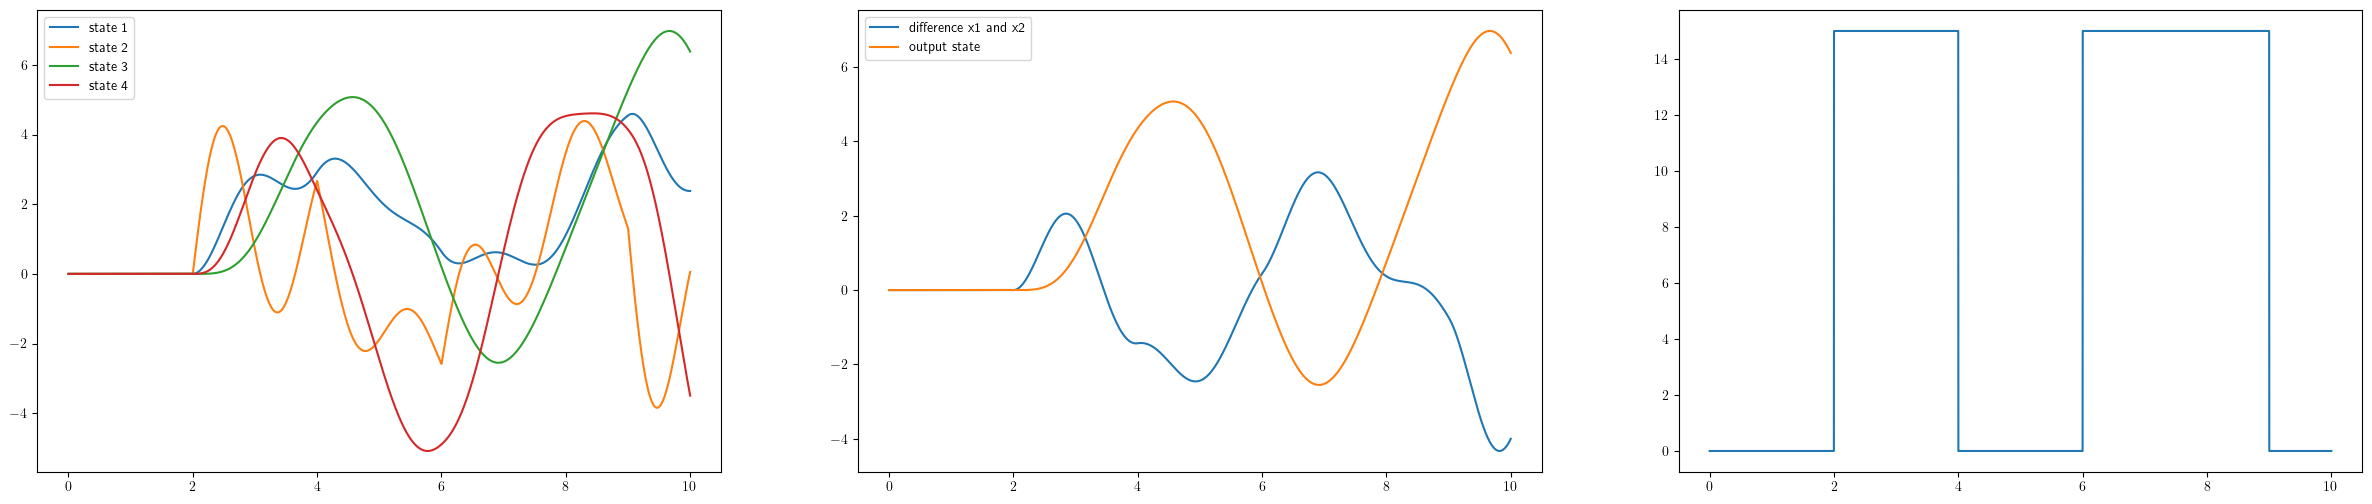

In [31]:
plt.figure(figsize=(30, 6))
plt.subplot(1,3,1)
plt.plot(t,x_out[:,0],label='state 1')
plt.plot(t,x_out[:,1],label='state 2')
plt.plot(t,x_out[:,2],label='state 3')
plt.plot(t,x_out[:,3],label='state 4')
#plt.ylim(bottom=-3, top=5)
plt.legend()

plt.subplot(1,3,2)
plt.plot(t,y_out[:,0],label='difference x1 and x2')
plt.plot(t,y_out[:,1],label='output state')
#plt.ylim(bottom=-3, top=5)
plt.legend()

plt.subplot(1,3,3)
plt.plot(t,u)

plt.show()

In [32]:
np.shape(x_out)

(4000, 4)

## Neural Network

#### Now we want to initialize the General Neural Dynamic Network (GDNN)

We want to train a Neural Network, that it takes in Data in such a way, that based on the last k samples at timestep i it makes a prediction for the i+1 timestep

In [33]:
X = x_out[:-1]
Y = x_out[1:]
print(np.shape(X))
print(np.shape(Y))

print(X[-4:-1])
print(Y[-4:-1])

(3999, 4)
(3999, 4)
[[ 2.37985641e+00 -2.70700935e-02  6.41539576e+00 -3.39615644e+00]
 [ 2.37981459e+00 -6.40055871e-03  6.40687279e+00 -3.42050612e+00]
 [ 2.37982429e+00  1.41366720e-02  6.39828900e+00 -3.44479635e+00]]
[[ 2.37981459e+00 -6.40055871e-03  6.40687279e+00 -3.42050612e+00]
 [ 2.37982429e+00  1.41366720e-02  6.39828900e+00 -3.44479635e+00]
 [ 2.37988518e+00  3.45397216e-02  6.38964455e+00 -3.46902644e+00]]


Let us try to manipulate the 

preprocess the data. Make pytorch tensors, that contain first the input and then the output

if we have 4 states we want to use the previous 5 timesteps to predict the next one time step


In [34]:
# numpy array manipulation
number_states = 4
k = 15   #number of timesteps we take into account to predict the future.

print(x_out.shape)

n = number_samples-k

new_x = np.zeros((n,number_states*k))

for i in range(n):
    new_x[i,:] = x_out[i:i+k].flatten()

print(new_x)
print(new_x.shape)


new_y = x_out[k:]
print(new_y.shape)


(4000, 4)
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 2.38523147e+00 -3.06937478e-01  6.52059532e+00 ... -6.40055871e-03
   6.40687279e+00 -3.42050612e+00]
 [ 2.38449173e+00 -2.84724312e-01  6.51287577e+00 ...  1.41366720e-02
   6.39828900e+00 -3.44479635e+00]
 [ 2.38380740e+00 -2.62617958e-01  6.50509361e+00 ...  3.45397216e-02
   6.38964455e+00 -3.46902644e+00]]
(3985, 60)
(3985, 4)


## Chat GPT Vorlage


In [35]:
input_tensor = torch.from_numpy(new_x).float()
target_tensor = torch.from_numpy(new_y).float()

input_tensor = input_tensor.unsqueeze(1)  # Adding a dimension to represent sequence length
target_tensor = target_tensor.unsqueeze(1)  # Adding a dimension to represent sequence length


input_tensor.shape

torch.Size([3985, 1, 60])

In [36]:
'''
import torch
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MultiLayerRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MultiLayerRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define a multi-layer RNN
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden state with zeros
        hidden = self.init_hidden(batch_size)

        # Forward through multiple RNN layers
        out, hidden = self.rnn(x, hidden)
        
        # Take the output from the last layer
        out = self.fc(out[:, -1, :])

        return out

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)


input_dim = number_states*k
output_dim = number_states
hidden_dim = 32
num_layers = 8  # Change this to the desired number of layers


model = MultiLayerRNN(input_dim, hidden_dim, output_dim, num_layers)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # adam optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)    #standards sgd optimizer

criterion = nn.MSELoss()  


num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(input_tensor)
    outputs = torch.squeeze(outputs, dim=1) # for dimensionality reasons
    # Compute loss
    loss = criterion(outputs, target_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
'''

'\nimport torch\nimport torch.nn as nn\n\n\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\n\nclass MultiLayerRNN(nn.Module):\n    def __init__(self, input_size, hidden_size, output_size, num_layers):\n        super(MultiLayerRNN, self).__init__()\n        self.hidden_size = hidden_size\n        self.num_layers = num_layers\n\n        # Define a multi-layer RNN\n        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)\n        self.fc = nn.Linear(hidden_size, output_size)\n\n    def forward(self, x):\n        batch_size = x.size(0)\n        \n        # Initialize hidden state with zeros\n        hidden = self.init_hidden(batch_size)\n\n        # Forward through multiple RNN layers\n        out, hidden = self.rnn(x, hidden)\n        \n        # Take the output from the last layer\n        out = self.fc(out[:, -1, :])\n\n        return out\n\n    def init_hidden(self, batch_size):\n        return torch.zeros(self.num_layers, bat

In [38]:
############# CHATGPT 2. VORSCHLAG RNN NETWORK

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class CustomRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Parameters for the RNN cell
        self.Wxh = nn.Linear(input_size, hidden_size)
        self.Whh = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, h):
        combined = self.Wxh(x) + self.Whh(h)
        return torch.tanh(combined)


class MultiLayerRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MultiLayerRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define a list of custom RNN cells
        self.rnn_cells = nn.ModuleList([CustomRNNCell(input_size if i == 0 else hidden_size, hidden_size)
                                        for i in range(num_layers)])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #batch_size = x.size(0) #alt, war falsch, wieso auch immer, hat den fehler verursacht mit den hohen dimensionalitaeten
        batch_size = 1
        #print(f'batch size = {batch_size}')    #zum debuggen benutzt

        # Initialize hidden state with zeros for each layer
        hidden_states = [torch.zeros(batch_size, self.hidden_size, device=device) for _ in range(self.num_layers)]
    
        # Forward through multiple RNN layers
        for layer_idx in range(self.num_layers):
            # Get the current RNN cell
            rnn_cell = self.rnn_cells[layer_idx]

            # Forward through the RNN cell
            hidden_states[layer_idx] = rnn_cell(x if layer_idx == 0 else hidden_states[layer_idx - 1],
                                                hidden_states[layer_idx])

        # Take the output from the last layer
        out = self.fc(hidden_states[-1])
        return out


input_dim = number_states * k
output_dim = number_states
hidden_dim = 8
num_layers = 8

model = MultiLayerRNN(input_dim, hidden_dim, output_dim, num_layers)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(input_tensor)
    #outputs = torch.squeeze(outputs, dim=1)  # for dimensionality reasons
    #outputs = outputs.squeeze(1)  # Adjusting the shape of outputs

    # Reshape the target tensor to match the shape of outputs
    #target_tensor = target_tensor.unsqueeze(1)  # Adjusting the shape of target tensor

    # Compute loss
    #print(f'outputs have shape: {outputs.shape}')
    #print(f'target tensor has shape: {target_tensor.shape}')
    loss = criterion(outputs, target_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()




    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


Epoch [100/10000], Loss: 0.8379223942756653
Epoch [200/10000], Loss: 0.581516683101654
Epoch [300/10000], Loss: 0.3175720274448395
Epoch [400/10000], Loss: 0.2079460620880127
Epoch [500/10000], Loss: 0.13384082913398743
Epoch [600/10000], Loss: 0.12347476929426193
Epoch [700/10000], Loss: 0.09273437410593033
Epoch [800/10000], Loss: 0.0956941619515419
Epoch [900/10000], Loss: 0.07023753970861435
Epoch [1000/10000], Loss: 0.06125618517398834
Epoch [1100/10000], Loss: 0.0641348585486412
Epoch [1200/10000], Loss: 0.047081124037504196
Epoch [1300/10000], Loss: 0.04210767149925232
Epoch [1400/10000], Loss: 0.0385284461081028
Epoch [1500/10000], Loss: 0.061486098915338516
Epoch [1600/10000], Loss: 0.0333692692220211
Epoch [1700/10000], Loss: 0.03325836360454559
Epoch [1800/10000], Loss: 0.03976476565003395
Epoch [1900/10000], Loss: 0.035449448972940445
Epoch [2000/10000], Loss: 0.028410863131284714
Epoch [2100/10000], Loss: 0.02955789491534233
Epoch [2200/10000], Loss: 0.02839180827140808
Ep

In [ ]:
print(input_dim, hidden_dim, output_dim, num_layers)


60 8 4 8


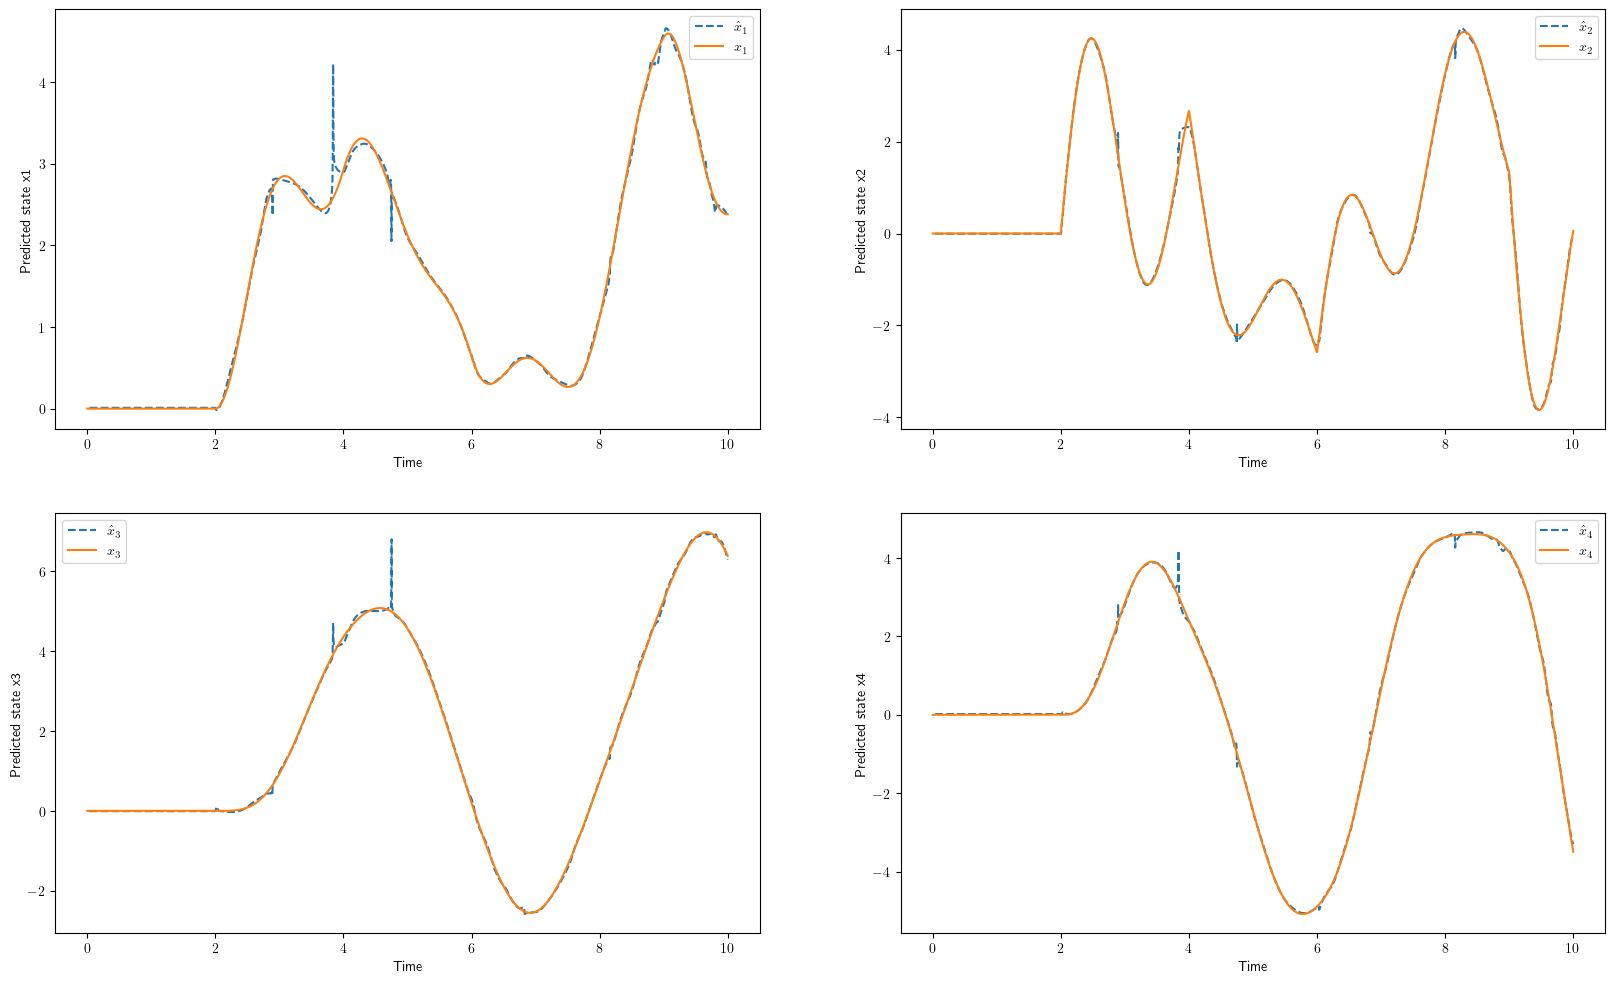

In [39]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Assuming you have a trained model and test data (test_input_tensor)
# Ensure the test_input_tensor has the shape (batch_size, sequence_length, input_dim)

# Assuming your model is already trained and available
# Define your model architecture, optimizer, criterion (MSELoss), etc.

# Assuming you've already defined and trained the model, let's proceed to prediction:

# Set the model to evaluation mode
model.eval()

# Get predictions from the model
with torch.no_grad():
    predicted_output = model(input_tensor)

# Convert predicted_output tensor to numpy array
predicted_output_np = predicted_output.cpu().numpy()

# Assuming test_input_tensor is your test input
# Plot the results
plt.figure(figsize=(20, 12))

# Plot ground truth (if available)
# Assuming ground_truth_output is the ground truth data
# plt.plot(ground_truth_output, label='Ground Truth', linestyle='--')

# Plot predicted output
#plt.title(r'Actual state $x$ vs. predicted state $\hat{x}$')

plt.subplot(2,2,1)
plt.plot(t[k:],predicted_output_np[:,0,0], label=r'$\hat{x}_1$', linestyle='--')
plt.plot(t,x_out[:,0],label=r"$x_1$")
plt.xlabel('Time')
plt.ylabel('Predicted state x1')
plt.legend()

plt.subplot(2,2,2)
plt.plot(t[k:],predicted_output_np[:,0,1], label=r'$\hat{x}_2$', linestyle='--')
plt.plot(t,x_out[:,1],label=r"$x_2$")
plt.xlabel('Time')
plt.ylabel('Predicted state x2')
plt.legend()

plt.subplot(2,2,3)
plt.plot(t[k:],predicted_output_np[:,0,2], label=r'$\hat{x}_3$', linestyle='--')
plt.plot(t,x_out[:,2],label=r"$x_3$")
plt.xlabel('Time')
plt.ylabel('Predicted state x3')
plt.legend()

plt.subplot(2,2,4)
plt.plot(t[k:],predicted_output_np[:,0,3], label=r'$\hat{x}_4$', linestyle='--')
plt.plot(t,x_out[:,3],label=r"$x_4$")
plt.xlabel('Time')
plt.ylabel('Predicted state x4')
plt.legend()

plt.show()



In [ ]:
predicted_output[:,7,0]

tensor([0.0045, 0.0045, 0.0045,  ..., 1.8531, 1.8484, 1.8436])

In [ ]:
predicted_output[:,2,0]

tensor([0.0045, 0.0045, 0.0045,  ..., 1.8531, 1.8484, 1.8436])

In [42]:
datum = input('bitte datum eingeben')        
filename = 'model_' + datum + '.pth'
torch.save(model.state_dict(), filename)

In [ ]:
a = input('something')

In [ ]:
a

'hallo'

array([0., 0., 0., 0.])

In [49]:
np.random.randint((20,20,20,20))-10

array([-4,  3,  6,  8])